# Connect to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Dataset

/content/drive/MyDrive/Dataset


In [ ]:
!ls

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
ls: cannot open directory '.': Transport endpoint is not connected


# TPU settings and packages

In [ ]:
using_tpu = False

In [ ]:
if using_tpu:
    !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
    !python pytorch-xla-env-setup.py

# Imports

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms, utils
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import h5py
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader
import random
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from multiprocessing import Process, Queue, Pool
import nibabel as nib
from tqdm import tqdm, trange
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from skimage.transform import resize

if using_tpu:
    # imports the torch_xla package
    import torch_xla
    import torch_xla.core.xla_model as xm

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


# Setting up TPU/GPU (if available)

In [ ]:
if using_tpu:
    device = xm.xla_device()
else:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Ensuring determinism (a.k.a. seeding the PRNG)

In [ ]:
random.seed(123)

# Preparing the data

## Setting up Kaggle API

In [ ]:
!pip3 install kaggle --user
!mkdir /root/.kaggle
!echo '### INSERT YOUR KAGGLE TOKEN HERE ###' > /root/.kaggle/kaggle.json

## Downloading dataset

In [ ]:
!kaggle datasets download awsaf49/brats20-dataset-training-validation

100% 4.16G/4.16G [01:22<00:00, 107MB/s] 
100% 4.16G/4.16G [01:22<00:00, 54.0MB/s]


In [ ]:
!ls

brats20-dataset-training-validation.zip


## Unpacking dataset

In [ ]:
!unzip -q brats20-dataset-training-validation.zip

## Setting up DataLoader

In [ ]:
class UnprocessedDataset(Dataset):
    def __init__(self, root_dir):
        self.files = os.listdir(root_dir)
        self.files = [file for file in self.files if file[-4:] != ".csv"]
        self.root_dir = root_dir
    
    def __len__(self):
        return len(self.files)
    
    def __get_file_path(self, idx, postfix):
        return self.root_dir + "/" + self.files[idx] + "/" + self.files[idx] + "_" + postfix + ".nii"
    
    def __getitem__(self, index):
        if type(index) == tuple:
            idx, s = index
        else:
            idx, s = index, slice(None, None)
        images = [nib.load(self.__get_file_path(idx, postfix)) for postfix in \
                  ["flair", "t1", "t2", "t1ce"]]
        images = np.array([np.asanyarray(image.dataobj) for image in images])
        images = np.swapaxes(images, 0, 3)
        images = images[s]
        y = np.array(nib.load(self.__get_file_path(idx, "seg")).dataobj)
        y = np.moveaxis(y, 2, 0)
        y = y[s]
        y = np.any(y, (0,1))
        return images, y


## Dimentionality reduction and scaling

### Choosing input data for normalization

In [ ]:
training_data = UnprocessedDataset("./BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData")

In [ ]:
random.seed(0)

X = []
for i in tqdm(random.choices(list(zip(range(len(training_data)), range(155))), k=200)):
    data = training_data[i][0]
    data = transform.resize(data, (224, 224, 3))
    X.append(data)

X = np.array(X)




  0%|          | 0/200 [00:00<?, ?it/s]


  0%|          | 1/200 [00:01<05:27,  1.65s/it]


  1%|          | 2/200 [00:02<04:46,  1.45s/it]


  2%|▏         | 3/200 [00:06<07:24,  2.26s/it]


  2%|▏         | 4/200 [00:11<09:37,  2.95s/it]


  2%|▎         | 5/200 [00:15<11:08,  3.43s/it]


  3%|▎         | 6/200 [00:20<11:56,  3.70s/it]


  4%|▎         | 7/200 [00:24<12:26,  3.87s/it]


  4%|▍         | 8/200 [00:28<12:04,  3.77s/it]


  4%|▍         | 9/200 [00:32<12:29,  3.92s/it]


  5%|▌         | 10/200 [00:36<12:51,  4.06s/it]


  6%|▌         | 11/200 [00:42<14:00,  4.45s/it]


  6%|▌         | 12/200 [00:46<13:43,  4.38s/it]


  6%|▋         | 13/200 [00:50<13:49,  4.44s/it]


  7%|▋         | 14/200 [00:51<09:57,  3.21s/it]


  8%|▊         | 15/200 [00:55<10:43,  3.48s/it]


  8%|▊         | 16/200 [01:00<12:03,  3.93s/it]


  8%|▊         | 17/200 [01:04<12:41,  4.16s/it]


  9%|▉         | 18/200 [01:10<13:30,  4.45s/it]


 10%|▉         | 19/200 [01:14<13:02,  4.32s/i

In [ ]:
X.shape

(200, 224, 224, 3)

### Finding scale values

In [ ]:
mean = np.mean(X, axis=(0, 1, 2))
std = np.std(X, axis=(0, 1, 2))
np.save("mean.npy", mean)
np.save("std.npy", std)
mean, std

(array([0.00126822, 0.00194388, 0.00209815]),
 array([0.00302834, 0.00460108, 0.00478389]))

In [ ]:
mean = np.load("mean.npy")
std = np.load("std.npy")

## Creating test-validation split

In [ ]:
np.random.seed(123)
train_index, test_index = train_test_split(list(range(len(training_data))), test_size=0.1)

## Transforming the dataset

In [ ]:
(i, j) = 302, 127
data, y = training_data[i]
datapoint = data[j]
datapoint = transform.resize(datapoint, (224, 224, 3))
datapoint = (datapoint - mean)/std
datapoint = np.moveaxis(datapoint, 2, 0)
datapoint = np.array([datapoint, y[j]], dtype=object)
np.save("./training_data/" + str(i) + "_" + str(j) + ".npy", datapoint)

In [ ]:
!mkdir training_data
for i in tqdm(train_index):
    data, y = training_data[i]
    for j in range(155):
        datapoint = data[j]
        datapoint = transform.resize(datapoint, (224, 224, 3))
        datapoint = (datapoint - mean)/std
        datapoint = np.moveaxis(datapoint, 2, 0)
        datapoint = np.array([datapoint, y[j]], dtype=object)
        np.save("./training_data/" + str(i) + "_" + str(j) + ".npy", datapoint)

!mkdir test_data
for i in tqdm(test_index):
    data, y = training_data[i]
    for j in range(155):
        datapoint = data[j]
        datapoint = transform.resize(datapoint, (224, 224, 3))
        datapoint = (datapoint - mean)/std
        datapoint = np.moveaxis(datapoint, 2, 0)
        datapoint = np.array([datapoint, y[j]], dtype=object)
        np.save("./test_data/" + str(i) + "_" + str(j) + ".npy", datapoint)

mkdir: cannot create directory ‘training_data’: File exists





  0%|          | 0/332 [00:00<?, ?it/s]


  0%|          | 1/332 [00:07<41:23,  7.50s/it]


  1%|          | 2/332 [00:15<41:47,  7.60s/it]


  1%|          | 3/332 [00:23<42:01,  7.66s/it]


  1%|          | 4/332 [00:35<49:03,  8.97s/it]


  2%|▏         | 5/332 [00:46<52:22,  9.61s/it]


  2%|▏         | 6/332 [01:03<1:04:15, 11.83s/it]


  2%|▏         | 7/332 [01:14<1:03:33, 11.73s/it]


  2%|▏         | 8/332 [01:26<1:03:35, 11.78s/it]


  3%|▎         | 9/332 [01:35<58:57, 10.95s/it]  


  3%|▎         | 10/332 [01:42<52:40,  9.81s/it]


  3%|▎         | 11/332 [01:55<57:00, 10.65s/it]


  4%|▎         | 12/332 [02:06<57:52, 10.85s/it]


  4%|▍         | 13/332 [02:17<58:04, 10.92s/it]


  4%|▍         | 14/332 [02:28<57:52, 10.92s/it]


  5%|▍         | 15/332 [02:36<52:03,  9.85s/it]


  5%|▍         | 16/332 [02:43<47:24,  9.00s/it]


  5%|▌         | 17/332 [02:54<51:08,  9.74s/it]


  5%|▌         | 18/332 [03:06<53:41, 10.26s/it]


  6%|▌         | 19/332 [03:17<55:09, 

## Creating mock dataset for unprocessed data (testing)

In [ ]:
class ModifiedDataset(Dataset):
    def __init__(self, root_dir, postfix=[str(i) for i in range(10)], transformation=None):
        self.files = os.listdir(root_dir)
        self.files = [file for file in self.files if file[-1] in postfix]
        self.root_dir = root_dir
        self.transformation = transformation
    
    def __len__(self):
        return len(self.files) * 155
    
    def __get_file_path(self, idx, postfix):
        return self.root_dir + "/" + self.files[idx] + "/" + self.files[idx] + "_" + postfix + ".nii"
    
    def __getitem__(self, index):
        idx, s = index//155, index % 155
        images = [nib.load(self.__get_file_path(idx, postfix)) for postfix in \
                  ["seg", "t1", "t2", "t1ce"]]
        images = np.array([np.asanyarray(image.dataobj) for image in images])
        images = np.swapaxes(images, 0, 3)
        images = images[s]
        if self.transformation is not None:
            images = self.transformation(images)
        y = np.array(nib.load(self.__get_file_path(idx, "seg")).dataobj)
        y = np.moveaxis(y, 2, 0)
        y = y[s]
        y = np.any(y, (0,1))
        return images, y

## Creating DataLoader for the new processed data

In [ ]:
class ProcessedDataset(Dataset):
    def __init__(self, root_dir, datapoints=None):
        if datapoints is None:
            self.files = os.listdir(root_dir)
            self.files = [file for file in self.files if file[-4:] != ".csv"]
        else:
            self.files = [str(i) + "_" + str(j) + ".npy" for i in datapoints for j in range(155)]
        self.root_dir = root_dir
    
    def __len__(self):
        return len(self.files)
    
    def __get_file_path(self, idx):
        return self.root_dir + "/" + self.files[idx] 

    def __getitem__(self, idx):
        if type(idx) == slice:
            data = [self[i] for i in range(len(self))[idx]]
            return [d[0] for d in data], [d[1] for d in data]
        data = np.load(self.__get_file_path(idx), allow_pickle=True)
        return data[0], data[1]

In [ ]:
training_data = ProcessedDataset("./test_data")

In [ ]:
training_data[0][0][:, 0, 0]

array([-0.4137443 , -0.41916734, -0.4353975 ])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


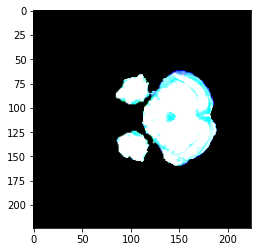

In [ ]:
plt.imshow(np.moveaxis(training_data[35][0], 0, 2))
plt.show()

## Creating train and test dataloaders

In [ ]:
train_dataloader = DataLoader(ProcessedDataset("./training_data", datapoints=train_index),
           batch_size=32, shuffle=True, sampler=None,
           batch_sampler=None, num_workers=16, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)
test_dataloader = DataLoader(ProcessedDataset("./test_data", datapoints=test_index),
           batch_size=32, shuffle=True, sampler=None,
           batch_sampler=None, num_workers=16, collate_fn=None,
           pin_memory=False, drop_last=False, timeout=0,
           worker_init_fn=None)
print(len(train_dataloader))
print(len(test_dataloader))

1609
180


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Setting up model

## Training function

In [ ]:
# Modified version of 
# https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#model-training-and-validation-code

def train_model(model, criterion, optimizer, scheduler, dataloaders, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_examples = 0
            # Iterate over data.
            time0 = time.time()
            for inputs, labels in dataloaders[phase]:
                print("Time loading:", time.time() - time0)
                time0 = time.time()
                print("New batch")
                inputs = inputs.float()
                inputs = inputs.to(device)
                labels = labels.float()
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    labels = labels.reshape_as(outputs)
                    preds = torch.round(torch.sigmoid(outputs))
                    loss = criterion(outputs, labels)
                    print(loss)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)
                running_examples += len(inputs)
                
                print("Time executing:", time.time() - time0)
                time0 = time.time()
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / running_examples
            epoch_acc = running_corrects.double() / running_examples

            if phase == "train":
                with open("loss.txt", "a") as f:
                    f.write('Epoch {}: Loss: {:.4f} Acc: {:.4f}\n'.format(epoch,
                        epoch_loss, epoch_acc))

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        #torch.save(model, "model_round11_epoch_" + str(epoch) + ".pt")
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Creating model

In [ ]:
model_conv = models.vgg16(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = True

# Parameters of newly constructed modules have requires_grad=True by default
model_conv.classifier[6] = nn.Linear(4096, 1)

model_conv = model_conv.to(device)

criterion = nn.BCEWithLogitsLoss()

# The learning rate has to be adjusted so that it is not high
# so that the network diverges in the start of the training.
optimizer_conv = optim.SGD(model_conv.classifier[6].parameters(), lr=0.00001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


# Training model

In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, {"train": train_dataloader, "val": test_dataloader}, num_epochs=24)

Epoch 0/23
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Streaming output truncated to the last 5000 lines.
Time executing: 0.43793821334838867
Time loading: 0.0007073879241943359
New batch
tensor(0.2094, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Time executing: 0.4427011013031006
Time loading: 8.107217073440552
New batch
tensor(0.2902, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Time executing: 0.5396840572357178
Time loading: 0.0008904933929443359
New batch
tensor(0.4293, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Time executing: 0.4381251335144043
Time loading: 0.0015490055084228516
New batch
tensor(0.2115, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Time executing: 0.43828916549682617
Time loading: 0.0009806156158447266
New batch
tensor(0.3957, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)
Time executing: 0.49657344818115234
Time loading: 0.0020246505737304688
New batch
tensor(0.4336, device='cuda:0', grad_fn=<BinaryCrossEntropyWithL

# Saving model

In [ ]:
torch.save(model_conv, "model.pt")